## Insertion Loss Fitted (Fit) 和 ILD

In [101]:
import skrf
from pylab import *

sp = skrf.Network('/Users/xdong/project/Autotester/temp/Autotest/parameters/test/40g.s4p')
print(sp)
sp.renumber([0, 1, 2, 3], [0, 2, 1, 3])
sp.se2gmm(p=2)
sp_mm = sp
print(sp_mm)
sp_mm.s21.s_db[:,0,0]


4-Port Network: '40g',  10000000.0-40000000000.0 Hz, 2001 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]
4-Port Network: '40g',  10000000.0-40000000000.0 Hz, 2001 pts, z0=[100.+0.j 100.+0.j  25.+0.j  25.+0.j]


array([ -0.23036043,  -0.32393348,  -0.39540817, ..., -32.71260189,
       -32.99632607, -33.69753066])

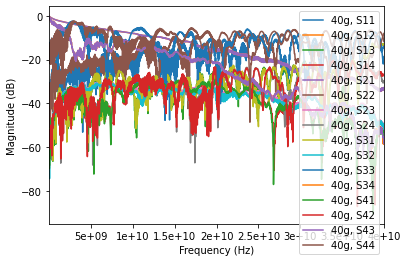

In [13]:
sp_mm.plot_s_db()

In [61]:
sp_mm.s_db[:101,1,0]  # get first 100 values of S21, also meas sdd21 in mixedmode
print(sp_mm.s_db[:,1,0].shape)
sp_mm.s_db[:,1,0].reshape(-1, 1)
print(sp_mm.s_db[:,1,0].reshape(-1, 1).shape)

(2001,)
(2001, 1)


#### plot s21

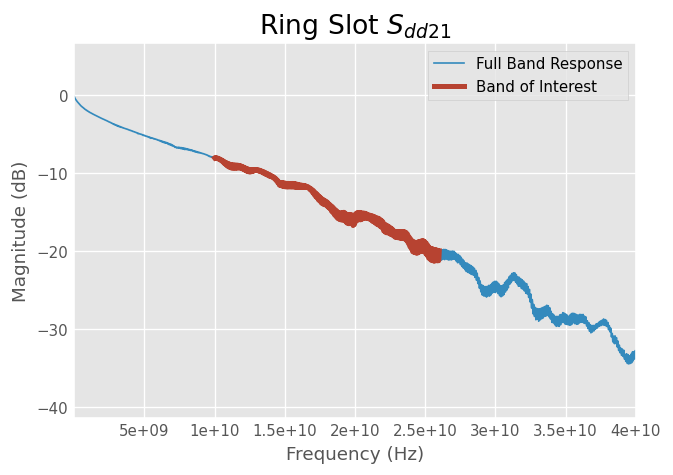

In [20]:
%matplotlib inline
skrf.stylely()

from matplotlib import pyplot as plt

plt.title('Ring Slot $S_{dd21}$')

sp_mm.s21.plot_s_db(label='Full Band Response')
sp_mm.s21['10-26ghz'].plot_s_db(lw=3,label='Band of Interest')

### 构造FIT算法

20.907629718438713
f.shape: (2001, 3)
f_denominator: (3, 3) [[ 3.40021910e-12 -3.49693151e-17  4.85563639e-28]
 [-3.49693151e-17  3.74624488e-22 -5.46191002e-33]
 [ 4.85563639e-28 -5.46191002e-33  8.49418464e-44]]
(3, 1) [[-4.80853585e-05]
 [-2.66798920e-10]
 [-8.22153189e-21]]


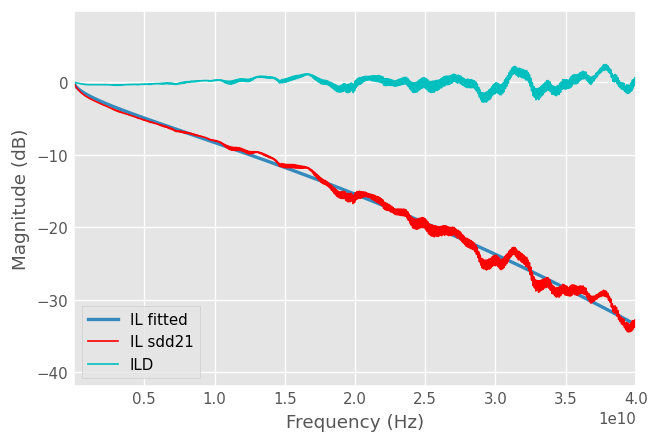

In [104]:
from math import sqrt
import numpy
from numpy.linalg import inv

def calc(a1, a2, a4, freq):
    il_fitted = a1*sqrt(freq) + a2*freq + a4*(freq**2)
    return il_fitted
il_fitted = calc(6, 1, 0.08, 5.15625)
print(il_fitted)

# 构造F矩阵
def matrix_f(sp):
    a1 = numpy.sqrt(sp_mm.f)
    a2 = sp_mm.f
    a3 = numpy.square(sp_mm.f)
    return numpy.array((a1, a2, a3)).swapaxes(1, 0) 
# 计算多项式系数矩阵mat_a    
f = matrix_f(sp_mm)
print('f.shape:', f.shape)
f_denominator = inv(f.transpose().dot(f))
print('f_denominator:', f_denominator.shape, f_denominator)
# a = f.transpose().dot(sp_mm.s_db[:,1,0].reshape(-1, 1)).dot(f_denominator)
mat_a = f_denominator.dot(f.transpose()).dot(sp_mm.s_db[:,1,0].reshape(-1, 1))
print(a.shape, a)

# 计算IL_fitted
list_a = mat_a.flatten().tolist()
a1 = list_a[0]; a2 = list_a[1]; a4 = list_a[2]
_il_fitted = [calc(a1, a2, a4, freq) for freq in sp_mm.f]

# plot
%matplotlib inline
skrf.stylely()

from matplotlib import pyplot as plt
# plt.title('IL fitted')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

plt.plot(sp_mm.f, _il_fitted, linewidth=2, label='IL fitted')
plt.plot(sp_mm.f, sp_mm.s21.s_db[:,0,0], color='r', label='IL sdd21')
plt.plot(sp_mm.f, sp_mm.s21.s_db[:,0,0] - _il_fitted, color='c', label='ILD')

plt.legend(loc='best')